Code for generating the results for semi-synthetic linear Gaussian graphs from [*bnlearn*](https://www.bnlearn.com/) (Figs. 11,17).

In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import numpy
import pandas
import networkx
from itertools import combinations, permutations
import logging
from causallearn.utils.cit import CIT
import collections
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
import copy

from causal_discovery.utils import *
from causal_discovery.pc_alg import PCAlgorithm
from causal_discovery.mb_by_mb import MBbyMBAlgorithm
from causal_discovery.sd_alg import SequentialDiscoveryAlgorithm
from causal_discovery.ldecc import LDECCAlgorithm

In [13]:
def get_bnlearn_graph_params(name):
  import pickle
  return pickle.load(open("data/bnlearn-%s.pkl" % name, "rb"))

def get_cov_matrix(G_weighted, G_std):
  A = G_weighted
  B = np.linalg.inv(np.eye(A.shape[0]) - A)
  noise_cov = G_std**2
  cov_matrix = B @ noise_cov @ B.T
  return cov_matrix

In [14]:
graph_to_tmt_outcome = {
    "magic-niab": {
        "treatment": "G266",
        "outcome": "HT",
    },
    "magic-irri": {
        "treatment": "G6003",
        "outcome": "BROWN",
    },
}

In [15]:
# one of "magic-niab" or "magic-irri".
graph_name = "magic-niab"

In [16]:
G_weighted, G_std, node_names = get_bnlearn_graph_params(graph_name)
graph_true = adj_matrix_to_nx_graph(G_weighted, node_names)

In [17]:
graph_true = nx.relabel_nodes(graph_true, {
    graph_to_tmt_outcome[graph_name]["treatment"]: "X",
    graph_to_tmt_outcome[graph_name]["outcome"]: "Y"
})

In [18]:
data = get_dataset(G_weighted, np.diag(G_std)**2, 1000, list(graph_true.nodes()))
data.head()

,YR.GLASS,Y,YR.FIELD,MIL,FT,G418,G311,G1217,G800,G866,...,G2318,G1294,G1800,YLD,FUS,G1750,G524,G775,G2835,G43
0,-1.091989,0.796907,-0.403872,-0.569469,-2.665879,-0.394184,-0.357452,-1.853955,-1.104084,0.910463,...,0.715239,-0.131579,0.309149,1.600596,1.102433,-0.882447,-0.210417,0.059481,0.205350,0.475546
1,-0.733643,1.627270,-0.334719,-0.201648,1.750155,-0.821588,-0.418812,-0.504237,0.017351,-0.697159,...,2.075532,1.124386,-0.104469,0.431668,-1.369764,-0.920874,0.092687,-0.086054,-0.064373,0.420616
2,-0.900280,-4.028214,0.148907,-0.138050,-1.198631,-0.176297,0.211950,0.099307,-1.927284,-0.510498,...,1.393339,0.649238,-0.219356,-0.825512,0.533359,1.609185,-1.328323,0.006370,-0.138648,0.537910
3,-0.321346,6.412923,-0.046021,0.685192,0.794203,0.252270,-0.398483,0.316916,-0.222170,1.185790,...,0.182922,-0.457161,0.234129,0.672461,0.024934,0.189189,0.187236,-0.586719,0.216116,0.498904
4,-0.567413,-6.033674,-0.252185,-0.175183,-1.185173,0.197365,0.121573,-1.012849,-1.774555,0.491739,...,0.866705,0.289031,0.603375,0.052746,0.195792,0.730385,0.622178,-0.142367,-0.169089,-0.569128


In [22]:
data.columns

Index(['YR.GLASS', 'Y', 'YR.FIELD', 'MIL', 'FT', 'G418', 'G311', 'G1217',
       'G800', 'G866', 'G795', 'G2570', 'G260', 'G2920', 'G832', 'G1896',
       'G2953', 'X', 'G847', 'G942', 'G200', 'G257', 'G2208', 'G1373', 'G599',
       'G261', 'G383', 'G1853', 'G1033', 'G1945', 'G1338', 'G1276', 'G1263',
       'G1789', 'G2318', 'G1294', 'G1800', 'YLD', 'FUS', 'G1750', 'G524',
       'G775', 'G2835', 'G43'],
      dtype='object')

In [81]:
sample_cov = data.cov().values

In [83]:
sample_cov.shape

(44, 44)

pandas.core.frame.DataFrame

In [46]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC
import networkx as nx
from lingam.utils import make_dot

2023-04-12 09:39:50,196 - /Users/tobiashatt/opt/anaconda3/lib/python3.9/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-04-12 09:39:50,323 - /Users/tobiashatt/opt/anaconda3/lib/python3.9/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [228]:
n_nodes = 10
degree=3
graph_level=5
weight_range=None

# data simulation, simulate true causal dag and train_data.
weighted_hierachical_dag = DAG.hierarchical(n_nodes=n_nodes, degree=degree, graph_level=graph_level, weight_range=weight_range ,seed=1)
weighted_hierachical_dag = weighted_hierachical_dag.transpose()

#Generate data
method = 'linear'
sem_type = 'gauss'
n = 2000

dataset = IIDSimulation(W=weighted_hierachical_dag, n=n, method=method, sem_type=sem_type)

#Nme columns
col_names = ['x_' + str(i) for i in range(dataset.X.shape[1]-1)] + ['Y']
df = pd.DataFrame(dataset.X, columns = col_names)


2023-04-12 13:13:27,943 - /Users/tobiashatt/opt/anaconda3/lib/python3.9/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


In [90]:
sample_cov = df.cov().values

In [105]:
sample_cov

array([[ 1.012e+00, -1.254e-02, -1.153e-02,  1.015e+00, -2.342e-02,
         1.016e+00,  1.057e+00, -4.531e-02, -4.041e-02,  1.988e+00],
       [-1.254e-02,  9.798e-01, -8.802e-03,  1.242e-03, -2.134e-02,
         3.520e-03, -2.040e-02,  1.001e+00,  4.053e-02,  7.129e-02],
       [-1.153e-02, -8.802e-03,  1.019e+00, -1.396e-02,  1.018e+00,
         9.981e-01, -1.798e-02,  1.031e+00, -6.467e-03,  9.913e-01],
       [ 1.015e+00,  1.242e-03, -1.396e-02,  2.000e+00, -2.383e-02,
         1.031e+00,  1.068e+00, -4.765e-02, -6.192e-02,  2.042e+00],
       [-2.342e-02, -2.134e-02,  1.018e+00, -2.383e-02,  2.018e+00,
         9.970e-01, -2.117e-02,  1.043e+00, -1.186e-02,  9.706e-01],
       [ 1.016e+00,  3.520e-03,  9.981e-01,  1.031e+00,  9.970e-01,
         3.033e+00,  1.060e+00,  9.964e-01, -7.923e-02,  3.988e+00],
       [ 1.057e+00, -2.040e-02, -1.798e-02,  1.068e+00, -2.117e-02,
         1.060e+00,  2.115e+00, -7.203e-02, -4.143e-02,  2.134e+00],
       [-4.531e-02,  1.001e+00,  1.031e+0

In [118]:
weighted_hierachical_dag

array([[0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [151]:
def get_subgraph(size: int, idx_treatment: int, idx_parents: list) -> numpy.ndarray:
    adj_matrix = np.zeros((size, size))
    adj_matrix[idx_parents, idx_treatment] = 1
    return adj_matrix

In [170]:
def get_subgraph_from_graph(graph: numpy.ndarray, idx_treatment: int) -> numpy.ndarray:
    idx_parents = list(np.argwhere(graph[:, idx_treatment] == 1).flatten())
    return get_subgraph(graph.shape[0], idx_treatment, idx_parents)

In [171]:
get_subgraph_from_graph(weighted_hierachical_dag, 5)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

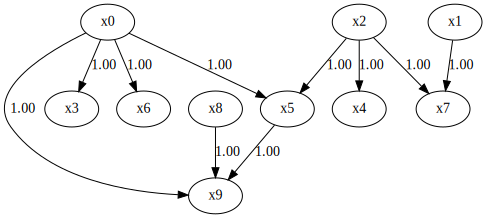

In [91]:
# plot predict_dag and true_dag
#GraphDAG(weighted_hierachical_dag)

make_dot(weighted_hierachical_dag.transpose())

In [229]:
df.rename(columns = {'x_5': 'X'}, inplace = True)

In [230]:
graph_true = adj_matrix_to_nx_graph(weighted_hierachical_dag, df.columns)

In [107]:
mb_by_mb_alg = MBbyMBAlgorithm(use_ci_oracle=False)

In [108]:
result_mb_by_mb = mb_by_mb_alg.run(df)

In [109]:
result_mb_by_mb

{'tmt_parents': set(),
 'tmt_children': {'Y'},
 'unoriented': {'x_3', 'x_6'},
 'non_colliders': {'Y': {'x_3', 'x_6'},
  'x_3': {'Y', 'x_6'},
  'x_6': {'Y', 'x_3'}}}

In [110]:
print("Total CI tests done: %d" % mb_by_mb_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_nodes_and_cov(list(df.columns),
                                    list(result_mb_by_mb["tmt_parents"]) + par,
                                    sample_cov)
    for par in get_all_combinations(result_mb_by_mb["unoriented"], 
                                    result_mb_by_mb["non_colliders"]))))

Total CI tests done: 159
Estimated ATE set: {1.1736920539434021, 1.3149972901058438, 1.1666774949299903}


In [112]:
sd_alg = SequentialDiscoveryAlgorithm(use_ci_oracle=False)
result_sd = sd_alg.run(df)
print("Total CI tests done: %d" % sd_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_nodes_and_cov(list(df.columns),
                                    list(result_sd["tmt_parents"]) + par,
                                    sample_cov)
    for par in get_all_combinations(result_sd["unoriented"], 
                                    result_sd["non_colliders"]))))

Total CI tests done: 96
Estimated ATE set: {1.1736920539434021, 1.3149972901058438, 1.1666774949299903}


In [114]:
result_sd

{'tmt_parents': set(),
 'tmt_children': {'Y'},
 'unoriented': {'x_3', 'x_6'},
 'non_colliders': {'Y': {'x_3', 'x_6'},
  'x_3': {'Y', 'x_6'},
  'x_6': {'Y', 'x_3'}}}

In [231]:
ldecc_alg = LDECCAlgorithm(use_ci_oracle=False, ldecc_do_checks=True)
result_ldecc = ldecc_alg.run(df)
print("Total CI tests done: %d" % ldecc_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_nodes_and_cov(list(df.columns),
                                    list(result_ldecc["tmt_parents"]) + par,
                                    sample_cov)
    for par in get_all_combinations(result_ldecc["unoriented"], 
                                    result_ldecc["non_colliders"]))))

Total CI tests done: 179
Estimated ATE set: {0.0, 1.3149972901058438, 1.4680984133230424}


In [115]:
result_ldecc

{'tmt_parents': set(),
 'tmt_children': {'Y'},
 'unoriented': {'x_3', 'x_6'},
 'non_colliders': {'Y': {'x_3', 'x_6'},
  'x_3': {'Y', 'x_6'},
  'x_6': {'Y', 'x_3'}}}

In [ ]:
get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
               for par in get_all_combinations(result_ldecc["unoriented"], result_ldecc["non_colliders"])

In [210]:
def get_subgraph_from_estimate(df, estimate) -> list:

    parents = [list(estimate['tmt_parents']) + par for par in get_all_combinations(estimate["unoriented"], estimate["non_colliders"])]
    label_to_idx = {j: i for i, j in enumerate(df.columns)}
    return [get_subgraph(df.shape[1], label_to_idx['X'], [label_to_idx[l] for l in par]) for par in parents]


In [232]:
t = get_subgraph_from_estimate(df, result_ldecc)

In [233]:
t

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]

In [226]:
true_sub_graph = get_subgraph_from_graph(weighted_hierachical_dag, 5)

In [227]:
met = MetricsDAG(t[1], true_sub_graph)
print(met.metrics)

{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.0233, 'shd': 3, 'nnz': 1, 'precision': 0.0, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/Users/tobiashatt/opt/anaconda3/lib/python3.9/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)


In [225]:
true_sub_graph

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
get_subgraph(df.shape[1], idx_treatment: int, idx_parents: list)

In [192]:
label_to_idx = {j: i for i, j in enumerate(df.columns)}

In [198]:
[label_to_idx[l] for l in parents[1]]

[6]

In [125]:
cpdag_oracle = dag_to_cpdag(graph_true)

In [126]:
cpdag_oracle

In [129]:
result = []

In [132]:
result = [get_ATE_using_cov(g, sample_cov) for g in generate_local_dags_from(cpdag_oracle)]
#result["oracle"]["neighbors"] = get_neighbor_types(cpdag_oracle, "X")                           

#result["oracle_sample_cov"]["ate"] = [get_ATE_using_cov(g, sample_cov)
 #                                   for g in generate_local_dags_from(cpdag_oracle)]

In [133]:
result

[-4.440892098500626e-16, -4.440892098500626e-16]

In [134]:
met = MetricsDAG(pc.causal_matrix, true_dag)
print(met.metrics)

NameError: name 'pc' is not defined

In [136]:
true_dag = dataset.B

In [138]:
true_dag

array([[0, 0, 0, 1, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
import ipyparallel as ipp

In [27]:
# Verify that ipcluster is running and import the necessary Python packages.

parallel_client = ipp.Client(debug=False)
dview = parallel_client[:]
# Execute an identity map in parallel.
ar = dview.map(lambda x: x, (i for i in range(0, 20000, 2)))
assert ar.get()[0] == 0

# Import the required Python packages.
with dview.sync_imports():
  import numpy
  import os
  import pandas
  import networkx
  from itertools import combinations, permutations
  import logging
  from causallearn.utils.cit import CIT
  import collections
  import copy
  import ipyparallel

  from causal_discovery.utils import orient_colliders, get_dataset, get_connected_component_with_node, remove_directed_only_edges, apply_meek_rules, adj_matrix_to_nx_graph, dag_to_cpdag, get_neighbor_types, get_all_combinations, get_ATE_using_nodes_and_cov, get_ATE_using_cov, generate_local_dags_from, to_dict    
  from causal_discovery.pc_alg import PCAlgorithm
  from causal_discovery.mb_by_mb import MBbyMBAlgorithm
  from causal_discovery.sd_alg import SequentialDiscoveryAlgorithm
  from causal_discovery.ldecc import LDECCAlgorithm
  
  try:
    from cPickle import dumps, loads, HIGHEST_PROTOCOL as PICKLE_PROTOCOL
  except ImportError:
    from pickle import dumps, loads, HIGHEST_PROTOCOL as PICKLE_PROTOCOL

# Make sure ipyparallel is still able to execute functions.
dview = parallel_client[:]
ar = dview.map(lambda x: x, (i for i in range(0, 20000, 2)))
assert ar.get()[0] == 0

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [40]:
def execute_iteration(params, num_samples, seed, progress_log_filepath=None):
  np = numpy
  nx = networkx
  
  # linearly scale down alpha.
  alpha = (32000 / num_samples) * 0.01

  MAX_TESTS = 7000
  
  result = {
      "graph_true_sample_cov_ate": None,
      "oracle": {
          "ate": None,
          "neighbors": None,
      },
      "oracle_sample_cov": {
          "ate": None,
      },
      "ldecc": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "ldecc-checks": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "mb-by-mb": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "sd-alg": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
  }

  G_weighted, G_std, node_names, graph_name, cov_matrix = params
  graph_true = adj_matrix_to_nx_graph(G_weighted, node_names)
  graph_true = nx.relabel_nodes(graph_true, {
      graph_to_tmt_outcome[graph_name]["treatment"]: "X",
      graph_to_tmt_outcome[graph_name]["outcome"]: "Y"
  })
  data = get_dataset(G_weighted, np.diag(G_std)**2, num_samples, 
                     list(graph_true.nodes()))
  sample_cov = data.cov().values

  result["graph_true_sample_cov_ate"] = get_ATE_using_cov(graph_true, sample_cov)

  cpdag_oracle = dag_to_cpdag(graph_true)
  result["oracle"]["ate"] = [get_ATE_using_cov(g, cov_matrix) 
                             for g in generate_local_dags_from(cpdag_oracle)]
  result["oracle"]["neighbors"] = get_neighbor_types(cpdag_oracle, "X")                           
  
  result["oracle_sample_cov"]["ate"] = [get_ATE_using_cov(g, sample_cov)
                                        for g in generate_local_dags_from(cpdag_oracle)]
  
  ldecc_alg = LDECCAlgorithm(use_ci_oracle=False, alpha=alpha,
                             ldecc_do_checks=False, max_tests=MAX_TESTS)
  result_ldecc = ldecc_alg.run(data)
  result["ldecc"]["ci_tests"] = to_dict(ldecc_alg.ci_test_calls)
  result["ldecc"]["neighbors"] = {
      "parents": result_ldecc["tmt_parents"],
      "children": result_ldecc["tmt_children"],
      "unoriented": result_ldecc["unoriented"], 
  }
  tmt_par = list(result_ldecc["tmt_parents"])
  ate_ldecc = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
               for par in get_all_combinations(result_ldecc["unoriented"], result_ldecc["non_colliders"])]
  result["ldecc"]["ate"] = ate_ldecc

  ldecc_alg = LDECCAlgorithm(use_ci_oracle=False, alpha=alpha,
                             ldecc_do_checks=True, max_tests=MAX_TESTS)
  result_ldecc = ldecc_alg.run(data)
  result["ldecc-checks"]["ci_tests"] = to_dict(ldecc_alg.ci_test_calls)
  result["ldecc-checks"]["neighbors"] = {
      "parents": result_ldecc["tmt_parents"],
      "children": result_ldecc["tmt_children"],
      "unoriented": result_ldecc["unoriented"], 
  }
  tmt_par = list(result_ldecc["tmt_parents"])
  ate_ldecc = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
               for par in get_all_combinations(result_ldecc["unoriented"], result_ldecc["non_colliders"])]
  result["ldecc-checks"]["ate"] = ate_ldecc

  mb_by_mb_alg = MBbyMBAlgorithm(use_ci_oracle=False, alpha=alpha, 
                                 max_tests=MAX_TESTS)
  result_mb = mb_by_mb_alg.run(data)
  result["mb-by-mb"]["ci_tests"] = to_dict(mb_by_mb_alg.ci_test_calls)
  result["mb-by-mb"]["neighbors"] = {
      "parents": result_mb["tmt_parents"],
      "children": result_mb["tmt_children"],
      "unoriented": result_mb["unoriented"], 
  }
  tmt_par = list(result_mb["tmt_parents"])
  ate_mb = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
            for par in get_all_combinations(result_mb["unoriented"], result_mb["non_colliders"])]
  result["mb-by-mb"]["ate"] = ate_mb

  sd_alg = SequentialDiscoveryAlgorithm(use_ci_oracle=False, alpha=alpha,
                                        max_tests=MAX_TESTS)
  result_sd = sd_alg.run(data)
  result["sd-alg"]["ci_tests"] = to_dict(sd_alg.ci_test_calls)
  result["sd-alg"]["neighbors"] = {
      "parents": result_sd["tmt_parents"],
      "children": result_sd["tmt_children"],
      "unoriented": result_sd["unoriented"], 
  }
  tmt_par = list(result_sd["tmt_parents"])
  ate_sd = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
            for par in get_all_combinations(result_sd["unoriented"], result_sd["non_colliders"])]
  result["sd-alg"]["ate"] = ate_sd
  
  if progress_log_filepath is not None:
    os.system("echo '%d' >> %s" % (seed, progress_log_filepath))

  np.random.seed(None)
  return result

In [41]:
def async_results_to_results(async_results, results):
  for N, ar in zip(results["sample_sizes"], async_results):
    if N not in results:
      results[N] = []
    for r in ar.get():
      results[N].append(r)
  return results

def execute_estimation_in_parallel(results, start_graph, end_graph, iters_per_graph=1):

  num_threads = len(parallel_client.ids)
  dview = parallel_client[:]

  num_graphs = end_graph - start_graph
  print("Executing %d iterations across %d engines" % (
      num_graphs*iters_per_graph, num_threads))

  dview["get_dataset"] = get_dataset
  dview["graph_to_tmt_outcome"] = graph_to_tmt_outcome
  dview["get_noise_matrix"] = get_noise_matrix
  dview["execute_iteration"] = execute_iteration

  graph_name = "magic-niab"
  
  G_weighted, G_std, node_names = get_bnlearn_graph_params(graph_name)
  cov_matrix = get_cov_matrix(G_weighted, G_std)
  params = (G_weighted, G_std, node_names, graph_name, cov_matrix)
  graph_true = adj_matrix_to_nx_graph(G_weighted, node_names)
  graph_true = nx.relabel_nodes(graph_true, {
      graph_to_tmt_outcome[graph_name]["treatment"]: "X",
      graph_to_tmt_outcome[graph_name]["outcome"]: "Y"
  })

  # RANDOM_SEED = 716697
  # np.random.seed(RANDOM_SEED)
  new_param_list = []
  for _ in range(start_graph, end_graph):

    for graph_iter in range(iters_per_graph):
      new_param_list.append(params)
      results["params"].append(params)
      results["ground_truth_ate"].append(get_ATE_using_cov(graph_true, cov_matrix))
      
  sample_sizes = [8000, 16000, 24000, 32000]
  results["sample_sizes"] = sample_sizes
  async_results = []
  for N in sample_sizes:
    print("%s: Starting iterations %d for N=%d" % (
        str(datetime.now()), len(new_param_list), N))
    
    def execute_estimation_iteration(i):
      return execute_iteration(new_param_list[i], N, (RANDOM_SEED + N + i))
    
    async_result = dview.map(execute_estimation_iteration, range(len(new_param_list)))
    async_results.append(async_result)

  np.random.seed(None)
  return results, async_results

In [42]:
results = {}
results.update({
    "params": [],
    "ground_truth_ate": [],
})

results, async_results = execute_estimation_in_parallel(results, 
                                                        start_graph=0,
                                                        end_graph=100,
                                                        iters_per_graph=1)

NameError: name 'parallel_client' is not defined

In [43]:
# Monitor progress of the tasks.
for ar in async_results:
  ar.wait_interactive(timeout=1)

NameError: name 'async_results' is not defined

In [45]:
results = async_results_to_results(async_results, results)

NameError: name 'async_results' is not defined

The code below plots the results.

In [33]:
# For the color map:
# https://gist.github.com/AndiH/c957b4d769e628f506bd

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
             
# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

In [34]:
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE+6)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE+6)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE + 4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE+4)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE+2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+20)  # fontsize of the figure title

In [35]:
plot_prop = {
    "pc-alg": ["dashed", tableau20blind[0], "o"],
    "ldecc": ["dashdot", tableau20blind[1], "^"],
    "ldecc-checks": ["solid", tableau20blind[5], "s"],
    "mb-by-mb": ["dashdot", tableau20blind[7], "D"],
    "sd-alg": ["dotted", tableau20blind[3], "v"],
}

In [44]:
def get_hausdorff_distance(arr_1, arr_2):

  arr_1 = np.array(arr_1)
  arr_2 = np.array(arr_2)

  def get_distance_point_from_array(point, arr):
    return np.min(np.abs(arr - point))

  dist_1_to_2 = np.max([get_distance_point_from_array(p, arr_2) for p in arr_1])
  dist_2_to_1 = np.max([get_distance_point_from_array(p, arr_1) for p in arr_2])

  return max(dist_1_to_2, dist_2_to_1)

def plot_mse(results):
  plt.figure(figsize=(6, 4))
  samples = results["sample_sizes"]

  dict_to_name = {
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  errors = collections.defaultdict(list)

  for N in samples:
    for k in dict_to_name.keys():
      errors[k].append([])

    for i, res in enumerate(results[N]):
      for k in dict_to_name.keys():
        errors[k][-1].append(get_hausdorff_distance(
            res["oracle"]["ate"], res[k]["ate"]
        )**2)

      
  samples = np.array(samples)
  mses = {}
  stds = {}
  for k in dict_to_name.keys():
    errors[k] = np.array(errors[k])
    mses[k] = np.median(errors[k], axis=-1)
    stds[k] = np.std(errors[k], axis=-1)

    plt.plot(samples, mses[k], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])
  
  plt.title("Median SE vs Sample size")
  plt.xlabel("Sample size")
  plt.ylabel("Median SE (Hausdorff distance)")
  plt.legend()
  plt.show()
  
plot_mse(results)

KeyError: 'sample_sizes'

<Figure size 600x400 with 0 Axes>

In [37]:
def plot_accuracy(results):

  dict_to_name = {
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  def get_detected_neighbors(r):
    return r["neighbors"]["parents"], r["neighbors"]["children"], r["neighbors"]["unoriented"]
  
  def is_locally_orientable(r):
    return len(r["oracle_sample_cov"]["ate"]) == 1

  def is_correct_adj_set(pa, ch, uo, pa_or, ch_or, uo_or):

    if uo == set() and uo == uo_or:
      return pa == pa_or
    
    return pa == pa_or and ch == ch_or and uo == uo_or

  N = len(results[results["sample_sizes"][0]])
  print("Total = %d" % N)

  incorrect_idxs_not_loc_orientable = []
  incorrect_idxs_loc_orientable = []

  same_count = collections.defaultdict(lambda: 0)
  correct_count = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
  correct_count_locally_orientable = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))

  for s in results["sample_sizes"]:
    for i in range(N):
      parents_or, children_or, uo_or = get_detected_neighbors(results[s][i]["oracle"])
      
      for k in dict_to_name.keys():
        parents, children, uo = get_detected_neighbors(results[s][i][k]) 
        if is_correct_adj_set(parents, children, uo, parents_or, children_or, uo_or):
          correct_count[k][s] += 1
        
  plt.figure(figsize=(6, 4))

  accuracy = {}
  samples = results["sample_sizes"]
  for k in dict_to_name.keys():
    accuracy[k] = np.array([correct_count[k][s] * 100 / N for s in samples])

    plt.plot(samples, accuracy[k], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])
  
  plt.title("Accuracy vs Sample size")
  plt.xlabel("Sample size")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  plt.show()

plot_accuracy(results)

KeyError: 'sample_sizes'

In [38]:
def plot_recall(results):

  dict_to_name = {
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  N = len(results[results["sample_sizes"][0]])
  
  correct_count = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
  
  for s in results["sample_sizes"]:
    for i in range(N):
      for k in dict_to_name.keys():
        
        if results[s][i]["graph_true_sample_cov_ate"] in results[s][i][k]["ate"]:
          correct_count[k][s] += 1
  
  plt.figure(figsize=(6, 4))
  
  coverage = {}
  samples = results["sample_sizes"]
  for k in dict_to_name.keys():
    coverage[k] = np.array([correct_count[k][s] * 100 / N for s in samples])

    plt.plot(samples, coverage[k], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])
  
  plt.title("Recall vs Sample size")
  plt.xlabel("Sample size")
  plt.ylabel("Recall (%)")
  plt.legend()
  plt.show()

plot_recall(results)

KeyError: 'sample_sizes'

In [39]:
def plot_number_of_tests(results):

  plt.figure(figsize=(6, 4))

  dict_to_name = {
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  samples = results["sample_sizes"]
  samples = np.array(samples)
  
  tests_count = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
  for k in dict_to_name.keys():
    for s in samples:
      tests_count[k][s] = np.mean([t[k]["ci_tests"]["total"] for t in results[s]])

  for k in dict_to_name.keys():
    plt.plot(samples, [tests_count[k][s] for s in samples], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])

  
  plt.title("Number of CI tests")
  plt.xlabel("Sample size")
  plt.ylabel("Number of CI tests")
  plt.legend()
  plt.show()

plot_number_of_tests(results)

KeyError: 'sample_sizes'

<Figure size 600x400 with 0 Axes>

The code below plots the distribution of conditional independence (CI) tests performed with a CI oracle by SD, LDECC, and MB-by-MB by repeatedly setting each node as the treatment (for computational reasons, we cap the maximum number of tests for each node to 20000).

In [34]:
def run_local_discovery_for_each_node(graph_true):

  MAX_TESTS = 20000

  node_to_tests = {}

  for node in graph_true.nodes():
    empty_df = pd.DataFrame(columns=list(graph_true.nodes()))

    mb_by_mb_alg = MBbyMBAlgorithm(use_ci_oracle=True, graph_true=graph_true,
                                   treatment_node=node, max_tests=MAX_TESTS)
    result_mb_by_mb = mb_by_mb_alg.run(empty_df)

    sd_alg = SequentialDiscoveryAlgorithm(use_ci_oracle=True, graph_true=graph_true,
                                          treatment_node=node, max_tests=MAX_TESTS)
    result_sd = sd_alg.run(empty_df)

    ldecc_alg = LDECCAlgorithm(use_ci_oracle=True, graph_true=graph_true, 
                              treatment_node=node, outcome_node=node,
                               max_tests=MAX_TESTS)
    result_ldecc = ldecc_alg.run(empty_df)
    
    node_to_tests[node] = {
        "mb-by-mb": mb_by_mb_alg.ci_test_calls["total"],
        "ldecc": ldecc_alg.ci_test_calls["total"],
        "sd-alg": sd_alg.ci_test_calls["total"],
    }

    print("Node done: %s, Tests: %s" % (node, node_to_tests[node]))
  
  return node_to_tests
  
node_to_tests = run_local_discovery_for_each_node(graph_true)

In [ ]:
def plot_test_statistics(node_to_tests):
  plt.figure(figsize=(6, 4))

  tests_mb_by_mb = [node_to_tests[k]["mb-by-mb"] for k in node_to_tests.keys()]
  tests_sd = [node_to_tests[k]["sd-alg"] for k in node_to_tests.keys()]
  tests_ldecc = [node_to_tests[k]["ldecc"] for k in node_to_tests.keys()]

  plt.hist([tests_mb_by_mb, tests_sd, tests_ldecc],
           label=["MB-by-MB", "SD", "LDECC"], 
           color=[plot_prop["mb-by-mb"][1], 
                  plot_prop["sd-alg"][1], plot_prop["ldecc"][1]])
  plt.legend()
  plt.title("Distribution of CI tests")
  plt.xlabel("Number of CI tests")
  plt.ylabel("Number of nodes")
  plt.show()


plot_test_statistics(node_to_tests)